In [1]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# Only Training data is used

df_FaultFree = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_Faulty_Training.RData')['faulty_training']

In [3]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,20.0,500.0,496,0.23419,3655.3,4461.7,9.3448,27.008,42.481,2703.0,...,53.670,23.350,61.061,20.719,40.999,38.653,47.386,47.528,40.212,17.659
4999996,20.0,500.0,497,0.26704,3647.4,4540.2,9.3546,27.034,42.671,2704.7,...,54.650,26.362,60.020,20.263,41.579,33.624,47.536,47.647,41.199,18.741
4999997,20.0,500.0,498,0.26543,3630.3,4571.6,9.4089,27.129,42.470,2705.1,...,54.274,26.521,59.824,20.189,41.505,40.967,52.437,47.802,41.302,23.199
4999998,20.0,500.0,499,0.27671,3655.7,4498.9,9.3781,27.353,42.281,2705.8,...,53.506,26.781,62.818,20.453,40.208,40.957,47.628,48.086,40.510,15.932


# Scale the dataset

In [4]:
# This is very important before you apply PCA

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(DF[DF['faultNumber']==0].iloc[3:])
df_scaled = sc.transform(DF[DF['faultNumber']==0].iloc[3:])


# Perform Linear PCA

In [5]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(df_scaled)

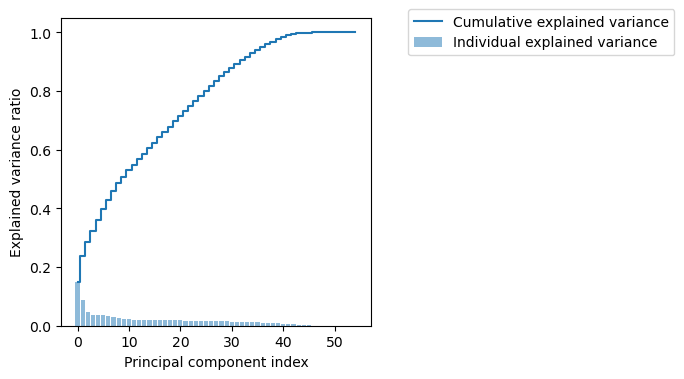

In [6]:
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.rcParams['figure.figsize'] = [4, 4]
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='upper right',bbox_to_anchor=(2, 1.05))
# plt.tight_layout()
plt.show()

# Anomaly detection using reconstruction loss

## Fit a PCA only using Fault-free data

In [51]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_faultFree = sc.fit_transform(DF[DF['faultNumber']==0].iloc[3:])

from sklearn.decomposition import PCA
pca_anomaly = PCA(n_components=0.90) # 90% variance in the data is captured, n_components=0.9
X_pca = pca_anomaly.fit_transform(X_faultFree)

In [52]:
np.sum(pca_anomaly.explained_variance_ratio_)

0.9046281198734055

## Create Function to obtain the reconstruction loss after inverse transform

In [65]:
def recon_loss(pca,X):
    #'pca' is the alredy fitted model on the "Fault-Free" data
    X_pca = pca.transform(X)
    X_recon = pca.inverse_transform(X_pca)
    reconstruction_loss = np.mean((X-X_recon)**2,axis=1)
    return reconstruction_loss

# Histogram for the reconstruction loss of the Fault Free data

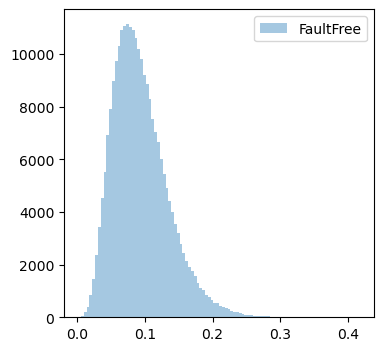

In [66]:
FaultFree_reconstruction_loss=recon_loss(pca=pca_anomaly,X=X_faultFree)

plt.rcParams['figure.figsize'] = [4, 4]
plt.hist(FaultFree_reconstruction_loss, bins=100,label='FaultFree',alpha=0.4)
plt.legend()
plt.show()

# Faulty data reconstruction loss

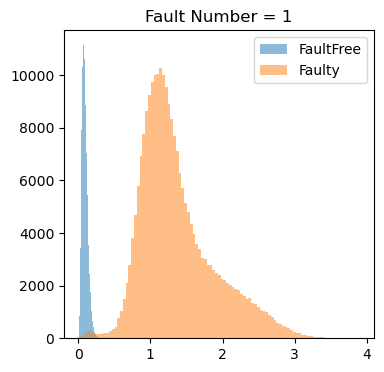

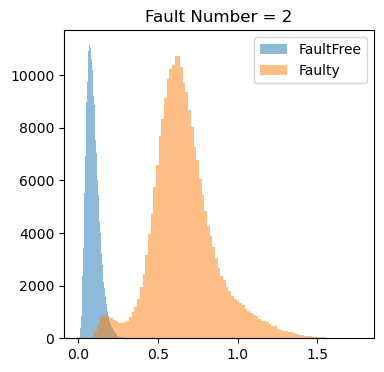

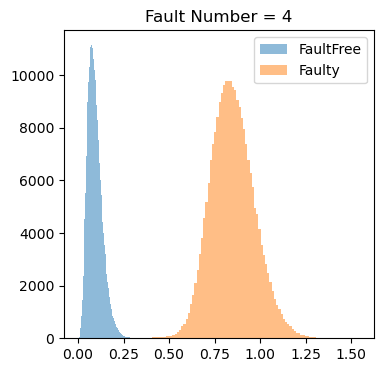

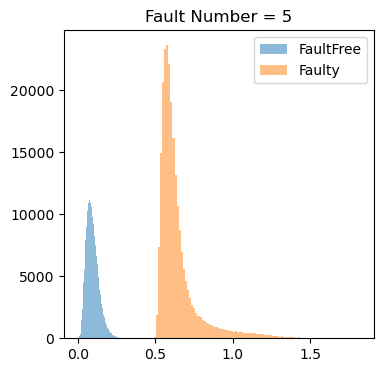

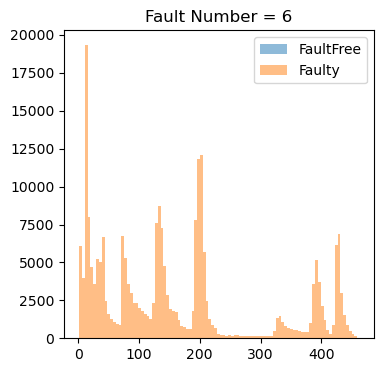

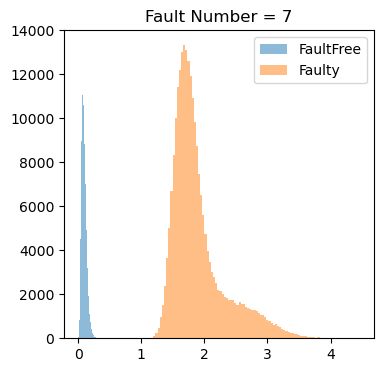

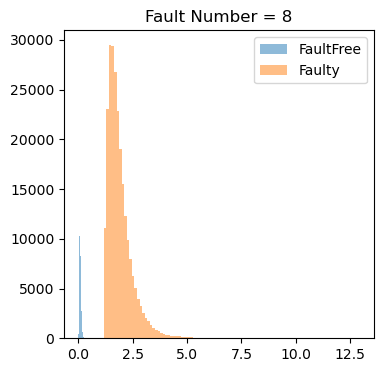

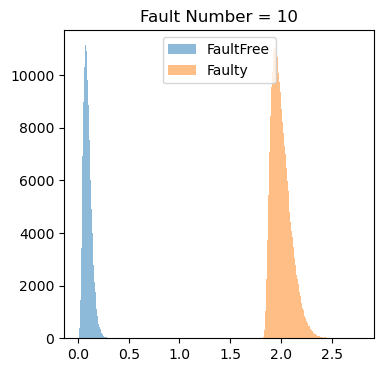

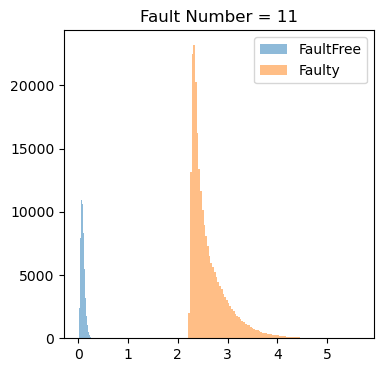

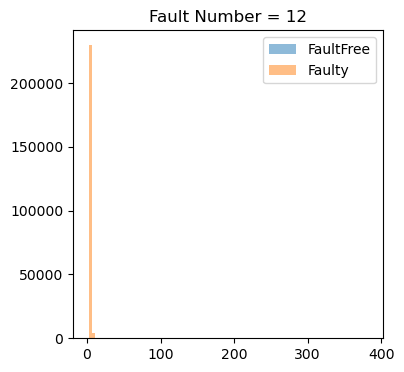

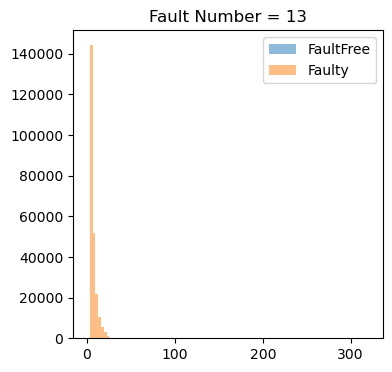

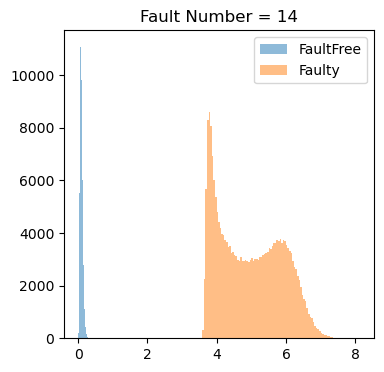

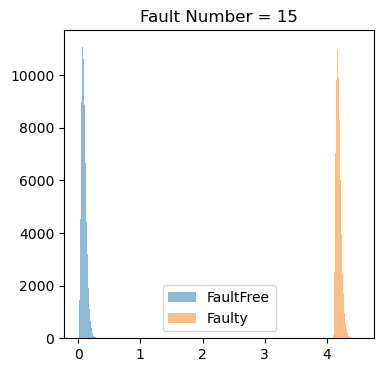

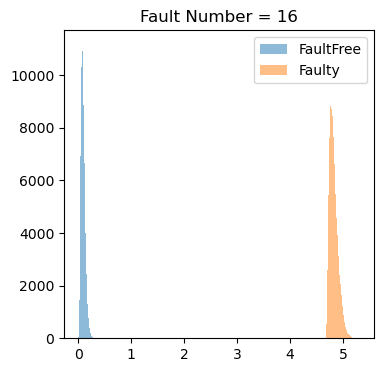

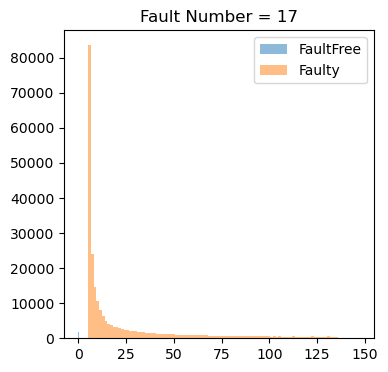

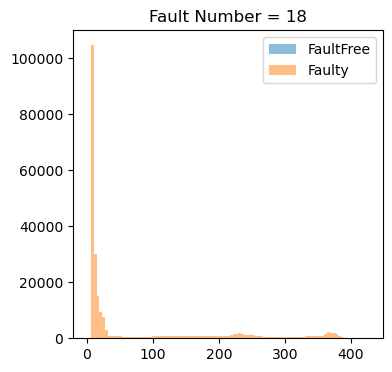

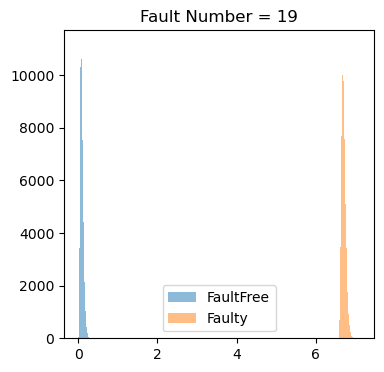

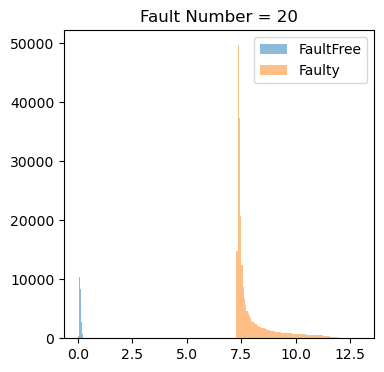

In [67]:

for F_num in range(1,21):
    temp_faulty=DF[(DF.faultNumber==F_num) & (DF['sample'] > 20.0 )] #DF[(DF.faultNumber==F_num) & (DF.simulationRun==1 )]
    # Scale the data to standardize
    X_faulty = sc.transform(temp_faulty.iloc[3:])
    # Obtain the reconstruction loss from the trained PCA
    faulty_reconstruction_loss = recon_loss(pca=pca_anomaly,X=X_faulty)

    plt.rcParams['figure.figsize'] = [4, 4]
    plt.hist(FaultFree_reconstruction_loss, bins=100,label='FaultFree',alpha=0.5)
    plt.hist(faulty_reconstruction_loss, bins=100,label='Faulty',alpha=0.5)
    plt.title(f'Fault Number = {F_num}')
    plt.legend()
    plt.show()

# Realtime Fault detection

In [68]:
# Obtain mean and standard deviation for 
mu = np.mean(FaultFree_reconstruction_loss)
std = np.std(FaultFree_reconstruction_loss)

In [69]:
# Obtain threshold from mu and std
threshold = mu+3*std
threshold

0.2165537799690433

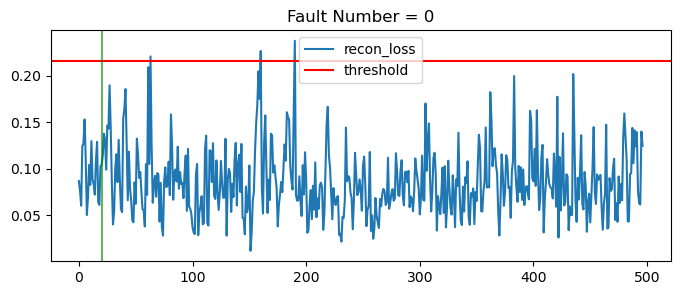

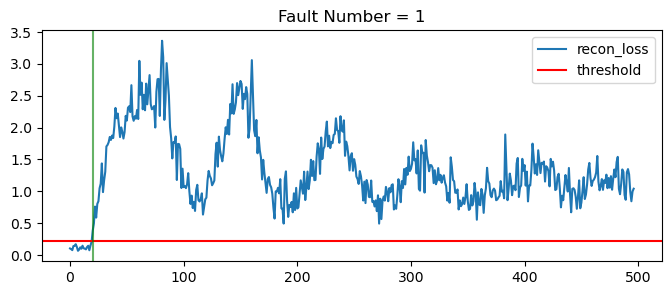

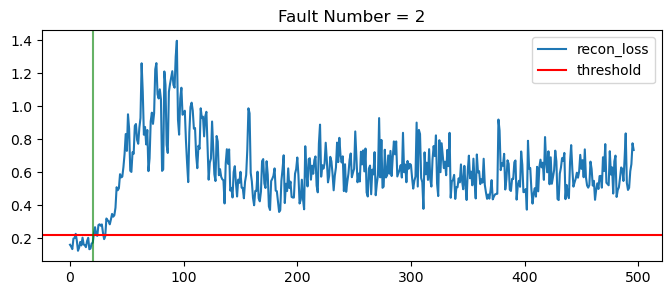

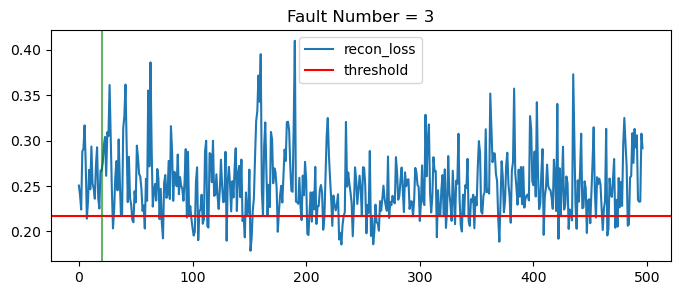

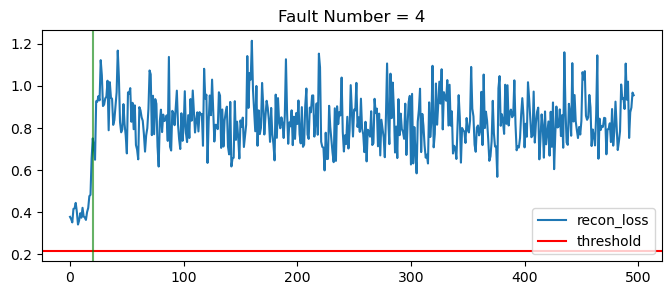

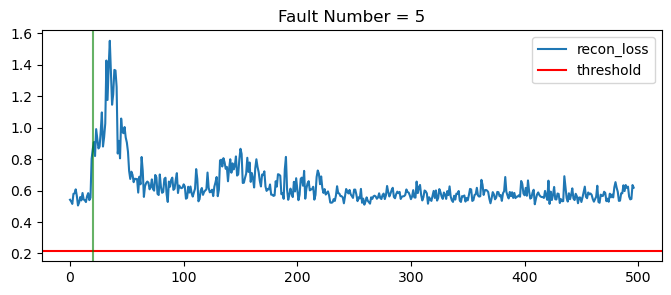

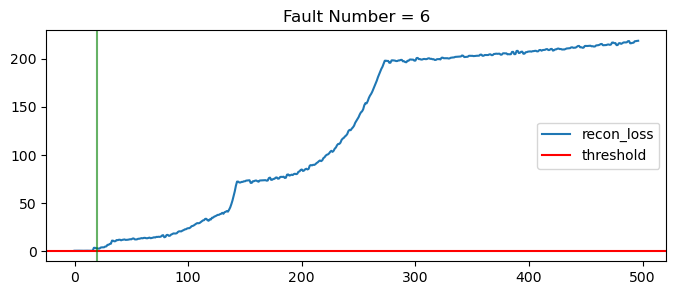

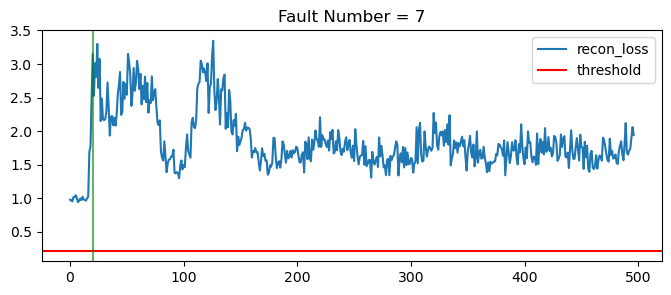

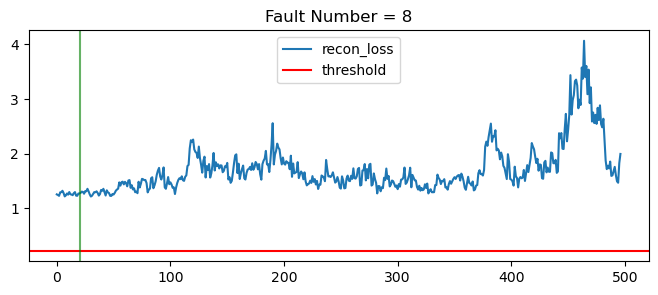

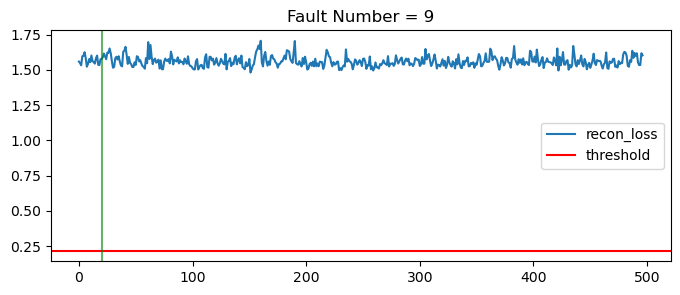

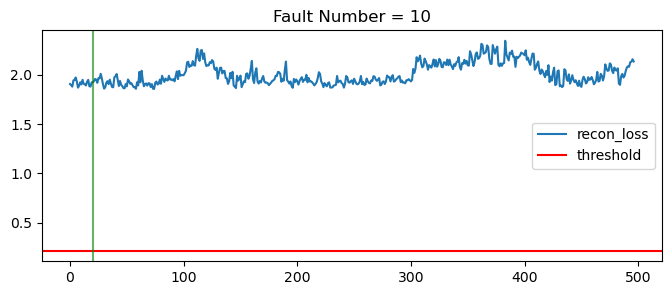

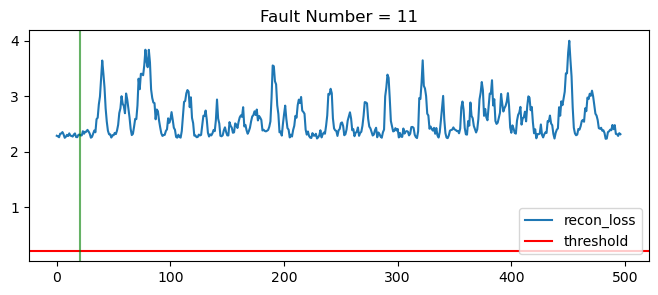

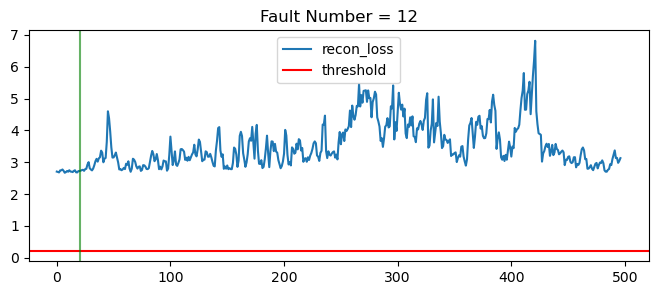

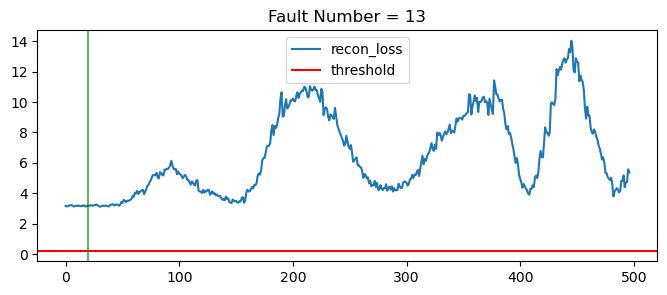

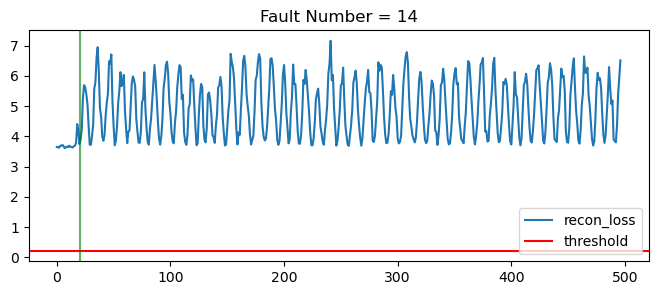

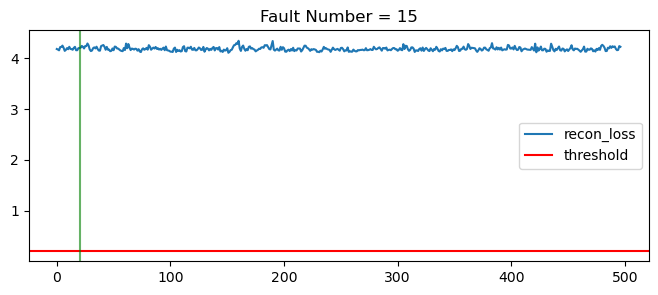

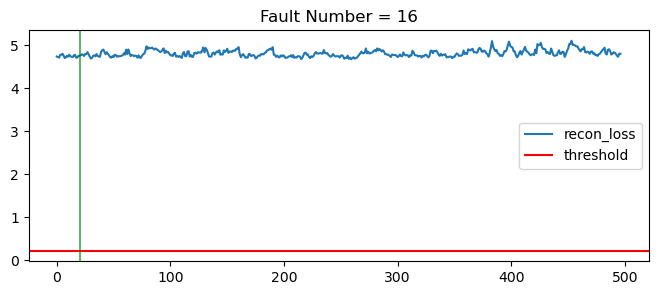

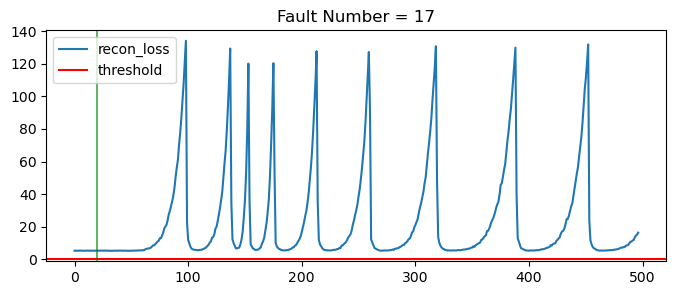

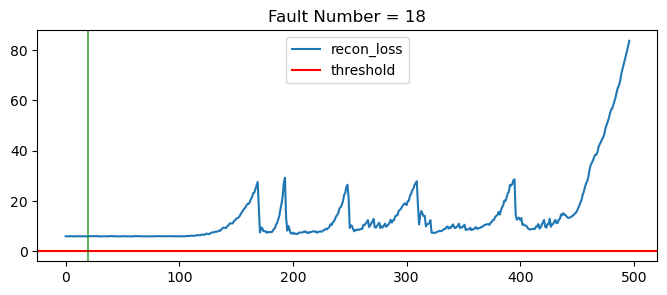

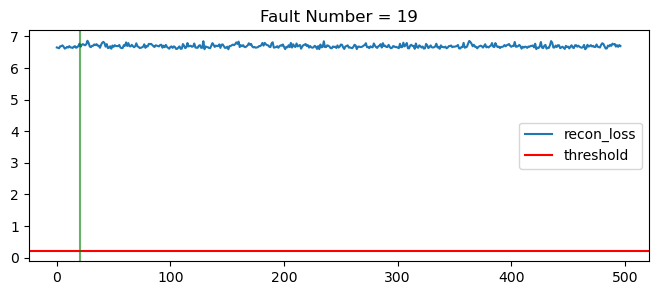

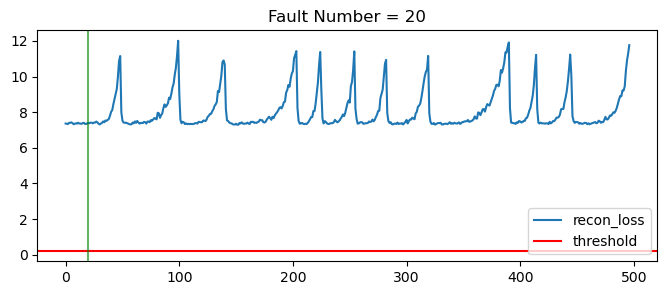

In [70]:

for F_num in range(0,21):
    # store the required fault class and simulation run
    temp = DF[(DF.faultNumber==F_num) & (DF.simulationRun==1 )] 
    # Standardization
    X_faulty = sc.transform(temp.iloc[3:])
    # Obtain reconstruction loss
    faulty_reconstruction_loss = recon_loss(pca=pca_anomaly,X=X_faulty) 

    plt.rcParams['figure.figsize'] = [8, 3]
    plt.plot(faulty_reconstruction_loss,label=f'recon_loss')
    plt.axhline(threshold,c='r',label='threshold')    #threshold value
    plt.axvline(20,c='g',alpha=0.6) #time of fault introduction
    plt.title(f'Fault Number = {F_num}')
    plt.legend()
    plt.show()

# Evaluate F1 score to compare performance

In [71]:
def combine_result(x,threshold):
    # IF reconstruction loss is grater than threshold THEN its a fault
    result= x > threshold
    result_float = [float(val) for val in result] 
    return result_float

In [72]:
for Fnum in [x for x in range(0,21) if x not in [3,9]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['simulationRun']==np.random.randint(1,500)) ]
    X_faulty = sc.transform(temp_df.iloc[3:])
    faulty_reconstruction_loss = recon_loss(pca=pca_anomaly,X=X_faulty) 
    
    #Obtain result using threshold testin of reconstruction loss
    result = combine_result(x=faulty_reconstruction_loss,threshold=threshold)
    
    #populate the true value (y_true) based of Fnum
    y_pred = combine_result(x=faulty_reconstruction_loss,threshold=threshold)
    if Fnum==0:
        y_true = np.repeat(0, len(y_pred))
    else:
        y_true = np.repeat(1, len(y_pred))
        y_true[0:21]=0 # Beacuse the fault was introduced after 20th sample
        

    # Obtain F1 score    
    from sklearn.metrics import f1_score,accuracy_score
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    print(f'The F1-Score for Fault_num={Fnum} is {f1}')
    print(f'The Accuracy-Score for Fault_num={Fnum} is {acc}')
    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm=confusion_matrix(y_true, y_pred)
    print(cm)

The F1-Score for Fault_num=0 is 0.49645390070921985
The Accuracy-Score for Fault_num=0 is 0.9859154929577465
[[490   7]
 [  0   0]]
The F1-Score for Fault_num=1 is 0.9599677809101892
The Accuracy-Score for Fault_num=1 is 0.993963782696177
[[ 18   3]
 [  0 476]]
The F1-Score for Fault_num=2 is 0.941810092495024
The Accuracy-Score for Fault_num=2 is 0.9899396378269618
[[ 20   1]
 [  4 472]]
The F1-Score for Fault_num=4 is 0.48920863309352514
The Accuracy-Score for Fault_num=4 is 0.9577464788732394
[[  0  21]
 [  0 476]]
The F1-Score for Fault_num=5 is 0.48920863309352514
The Accuracy-Score for Fault_num=5 is 0.9577464788732394
[[  0  21]
 [  0 476]]
The F1-Score for Fault_num=6 is 0.48920863309352514
The Accuracy-Score for Fault_num=6 is 0.9577464788732394
[[  0  21]
 [  0 476]]
The F1-Score for Fault_num=7 is 0.48920863309352514
The Accuracy-Score for Fault_num=7 is 0.9577464788732394
[[  0  21]
 [  0 476]]
The F1-Score for Fault_num=8 is 0.48920863309352514
The Accuracy-Score for Fault

# Get the mean-F1 score of all types of faults from (0-21) for bench marking

In [73]:
F1_all = [] #initialize the emplty list of F1 score
Acc_all = []
for Fnum in [x for x in range(0,21) if x not in [3,9]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['simulationRun']==np.random.randint(1,500))]
    X_faulty = sc.transform(temp_df.iloc[3:])
    faulty_reconstruction_loss = recon_loss(pca=pca_anomaly,X=X_faulty) 
    
    
    
    y_pred = combine_result(x=faulty_reconstruction_loss,threshold=threshold)
    if Fnum==0:
        y_true = np.repeat(0, len(y_pred))
    else:
        y_true = np.repeat(1, len(y_pred))
        y_true[0:21]=0 # Beacuse the fault was introduced after 20th sample

    # Obtain F1 score    
    from sklearn.metrics import f1_score,accuracy_score
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    F1_all.append(f1)
    Acc_all.append(acc)
    
print(f'The mean F1-Score for PCA-reconstruction method is {np.mean(np.array(F1_all))}')
print(f'The mean Accuracy-Score for PCA-reconstruction method is {np.mean(np.array(Acc_all))}')

The mean F1-Score for PCA-reconstruction method is 0.5388700776864892
The mean Accuracy-Score for PCA-reconstruction method is 0.9627237106851636
